### 0. Import libraries and import data

#### Questions:

**Q1:** Difference between flair tokenizer and Hugging Face tokenizer?\
**Q2:** Where do we have the POS and NER for questions?

#### Observations:

- There may be named entities composed by several words, but the predicted tags can be unmatched. (e.g.: B-LOC then I-MISC)
- Only ~3.6% (validation) / ~4.4% (train) of words have 3 or more predicted named entities for validation and .
- The tokenizer used by Flair extracts symbols like . or ) as separate words.
- TinyBERT tokenizer extracts symbols like . or ) as separate words and lowercases words.
- For unknown words, TinyBERT tokenizer splits the words in subwords and the subwords start with ##.
- TinyBERT tokenizer extarcts ' and s as 2 separated tokens and words with hyphens as 3 tokens, while Flair as one.
- Unrecognized tokens by the POS tagger are **$ '' , -LRB- -RRB- . : ``**

In [1]:
import re
import json
import numpy as np
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt

from flair.data import Sentence
from flair.models import SequenceTagger
from transformers import AutoTokenizer

In [29]:
input_file_path = "../../data/squad_data_validation_pos_ner.json"
data = []

with open(input_file_path) as f:
    for line in f:
        data.append(json.loads(line))

### 1. Analyze POS tags

In [12]:
def analyze_sampled_context(data, example_index):
    context = ""
    pos_set = set()
    original_context = data[example_index]["context"]


    for word_pos in data[example_index]["POS_context"]:
        word, pos = list(word_pos.values())[0]
        context += word
        context += " "
        pos_set.add(pos)

    print(f"Reconstructed context:\n{context}")
    print(f"\nOriginal context:\n{original_context}")
    print(f"\nPOS set: {pos_set}")

    return context

In [21]:
reconstructed_context = analyze_sampled_context(data, 0)

Reconstructed context:
Architecturally , the school has a Catholic character . Atop the Main Building 's gold dome is a golden statue of the Virgin Mary . Immediately in front of the Main Building and facing it , is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes " . Next to the Main Building is the Basilica of the Sacred Heart . Immediately behind the basilica is the Grotto , a Marian place of prayer and reflection . It is a replica of the grotto at Lourdes , France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858 . At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ) , is a simple , modern stone statue of Mary . 

Original context:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the l

In [24]:
def get_all_pos_tags(data):
    pos_set = set()

    for example_index in range(len(data)):
        for word_pos in data[example_index]["POS_context"]:
            _, pos = list(word_pos.values())[0]
            pos_set.add(pos)

    all_pos = sorted(list(pos_set))

    print(f"\nPOS set: {all_pos}")

In [25]:
get_all_pos_tags(data)


POS set: ['$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'ADD', 'AFX', 'CC', 'CD', 'DT', 'EX', 'FW', 'HYPH', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NFP', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'XX', '``']


In [36]:
data[0]["POS_context"]

[{'0': ['Architecturally', 'RB']},
 {'1': [',', ',']},
 {'2': ['the', 'DT']},
 {'3': ['school', 'NN']},
 {'4': ['has', 'VBZ']},
 {'5': ['a', 'DT']},
 {'6': ['Catholic', 'JJ']},
 {'7': ['character', 'NN']},
 {'8': ['.', ',']},
 {'9': ['Atop', 'IN']},
 {'10': ['the', 'DT']},
 {'11': ['Main', 'NNP']},
 {'12': ['Building', 'NNP']},
 {'13': ["'s", 'POS']},
 {'14': ['gold', 'JJ']},
 {'15': ['dome', 'NN']},
 {'16': ['is', 'VBZ']},
 {'17': ['a', 'DT']},
 {'18': ['golden', 'JJ']},
 {'19': ['statue', 'NN']},
 {'20': ['of', 'IN']},
 {'21': ['the', 'DT']},
 {'22': ['Virgin', 'NNP']},
 {'23': ['Mary', 'NNP']},
 {'24': ['.', ',']},
 {'25': ['Immediately', 'RB']},
 {'26': ['in', 'IN']},
 {'27': ['front', 'NN']},
 {'28': ['of', 'IN']},
 {'29': ['the', 'DT']},
 {'30': ['Main', 'NNP']},
 {'31': ['Building', 'NNP']},
 {'32': ['and', 'CC']},
 {'33': ['facing', 'VBG']},
 {'34': ['it', 'PRP']},
 {'35': [',', ',']},
 {'36': ['is', 'VBZ']},
 {'37': ['a', 'DT']},
 {'38': ['copper', 'NN']},
 {'39': ['statue', '

In [8]:
def check_square_brackets(data):
    count = 0 

    for example_index in range(len(data)):
        if "[" in data[example_index]["context"] or "]" in data[example_index]["context"]:
            count += 1

    print(f"Number of examples that contain a square bracket: {count}")

In [9]:
check_square_brackets(data)

Number of examples that contain a square bracket: 7042


### 2. Analyze named entities

In [6]:
def count_ner_number(data):
    ner_number = []

    for example in data:
        for word_ners in example["NER_context"]:
            ner_number.append(len(list(word_ners.values())[0]))

    words_no = len(ner_number)
    print("Percentage of words that have a specific number of named entities:")

    for number in range(1, len(set(ner_number))+ 1):
        print(f"{number} - {round(Counter(ner_number)[number] / words_no * 100, 2)}%")

In [7]:
count_ner_number(data)

Percentage of words that have a specific number of named entities:
1 - 76.5%
2 - 19.07%
3 - 3.87%
4 - 0.52%
5 - 0.03%
6 - 0.0%


In [68]:
data[0]["NER_context"]

[{'0': [['Super', 'B-MISC', '0.9410769']]},
 {'1': [['Bowl', 'E-MISC', '0.98900163']]},
 {'5': [['American', 'S-MISC', '0.9956988']]},
 {'14': [['National', 'B-MISC', '0.5022688'],
   ['National', 'B-LOC', '0.24889919'],
   ['National', 'B-ORG', '0.19581686']]},
 {'15': [['Football', 'I-MISC', '0.6923045'],
   ['Football', 'I-ORG', '0.18027079'],
   ['Football', 'I-LOC', '0.12511595']]},
 {'16': [['League', 'E-ORG', '0.60113037'],
   ['League', 'E-MISC', '0.38968554']]},
 {'18': [['NFL', 'S-ORG', '0.99872464']]},
 {'26': [['American', 'B-MISC', '0.7453571'],
   ['American', 'B-ORG', '0.13586394']]},
 {'27': [['Football', 'I-MISC', '0.9433532']]},
 {'28': [['Conference', 'E-MISC', '0.74766535'],
   ['Conference', 'I-MISC', '0.13813968'],
   ['Conference', 'E-ORG', '0.11040713']]},
 {'30': [['AFC', 'S-ORG', '0.9421894']]},
 {'33': [['Denver', 'B-ORG', '0.9724425']]},
 {'34': [['Broncos', 'E-ORG', '0.99889153']]},
 {'37': [['National', 'B-MISC', '0.53137046'],
   ['National', 'B-ORG', '0.

In [20]:
tagger = SequenceTagger.load("ner-fast")

2023-10-20 19:14:53,106 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [28]:
sentence = Sentence('Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levis Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.')
tagger.predict(sentence)
print(sentence)

Sentence[147]: "Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levis Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50." → ["Super Bowl"/MISC, "American"/MISC, "National Football League"/ORG, "NFL"/ORG, "American Football Conference"/MISC, "AFC"/ORG, "Denver Broncos"/ORG, "National Football Conference"/ORG, "NFC"/ORG, "Carolina

### 3. Analyze TinyBERT tokenizer

In [107]:
tokenizer = AutoTokenizer.from_pretrained("../../models/fine_tuned_tiny_bert_8_0.0003_tokenizer/")

input_ids = tokenizer.encode("", 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.')

tokens = tokenizer.convert_ids_to_tokens(input_ids)
tokens

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['[CLS]',
 '[SEP]',
 'super',
 'bowl',
 '50',
 'was',
 'an',
 'american',
 'football',
 'game',
 'to',
 'determine',
 'the',
 'champion',
 'of',
 'the',
 'national',
 'football',
 'league',
 '(',
 'nfl',
 ')',
 'for',
 'the',
 '2015',
 'season',
 '.',
 'the',
 'american',
 'football',
 'conference',
 '(',
 'afc',
 ')',
 'champion',
 'denver',
 'broncos',
 'defeated',
 'the',
 'national',
 'football',
 'conference',
 '(',
 'nfc',
 ')',
 'champion',
 'carolina',
 'panthers',
 '24',
 '–',
 '10',
 'to',
 'earn',
 'their',
 'third',
 'super',
 'bowl',
 'title',
 '.',
 'the',
 'game',
 'was',
 'played',
 'on',
 'february',
 '7',
 ',',
 '2016',
 ',',
 'at',
 'levi',
 "'",
 's',
 'stadium',
 'in',
 'the',
 'san',
 'francisco',
 'bay',
 'area',
 'at',
 'santa',
 'clara',
 ',',
 'california',
 '.',
 'as',
 'this',
 'was',
 'the',
 '50th',
 'super',
 'bowl',
 ',',
 'the',
 'league',
 'emphasized',
 'the',
 '"',
 'golden',
 'anniversary',
 '"',
 'with',
 'various',
 'gold',
 '-',
 'themed',
 'init

In [29]:
tokenizer = AutoTokenizer.from_pretrained("../../models/fine_tuned_tiny_bert_8_0.0003_tokenizer/")
tokenizer.add_tokens(["[SYM]"])

input_ids = tokenizer.encode("", 'Super Bowl [SYM], 50, was an American football')

tokens = tokenizer.convert_ids_to_tokens(input_ids)
tokens

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['[CLS]',
 '[SEP]',
 'super',
 'bowl',
 '[SYM]',
 ',',
 '50',
 ',',
 'was',
 'an',
 'american',
 'football',
 '[SEP]']

### 4. Compare Flair and TinyBERT tokenizers

In [104]:
reconstructed_context_tokenizer = " ".join(tokens).replace(" ##", "").replace("[SEP]", "").replace("[CLS]", "").replace("  ", " ").strip(" ")
print(f"Reconstructed context processed by TinyBERT tokenizer:\n{reconstructed_context_tokenizer}")
print(f"\nReconstructed context processed by Flair:\n{reconstructed_context}")

Reconstructed context processed by TinyBERT tokenizer:
super bowl 50 was an american football game to determine the champion of the national football league ( nfl ) for the 2015 season . the american football conference ( afc ) champion denver broncos defeated the national football conference ( nfc ) champion carolina panthers 24 – 10 to earn their third super bowl title . the game was played on february 7 , 2016 , at levi ' s stadium in the san francisco bay area at santa clara , california . as this was the 50th super bowl , the league emphasized the " golden anniversary " with various gold - themed initiatives , as well as temporarily suspending the tradition of naming each super bowl game with roman numerals ( under which the game would have been known as " super bowl l " ) , so that the logo could prominently feature the arabic numerals 50 .

Reconstructed context processed by Flair:
Super Bowl 50 was an American football game to determine the champion of the National Football Lea

In [106]:
list(zip(reconstructed_context_tokenizer.split(" "), reconstructed_context.split(" ")))

[('super', 'Super'),
 ('bowl', 'Bowl'),
 ('50', '50'),
 ('was', 'was'),
 ('an', 'an'),
 ('american', 'American'),
 ('football', 'football'),
 ('game', 'game'),
 ('to', 'to'),
 ('determine', 'determine'),
 ('the', 'the'),
 ('champion', 'champion'),
 ('of', 'of'),
 ('the', 'the'),
 ('national', 'National'),
 ('football', 'Football'),
 ('league', 'League'),
 ('(', '('),
 ('nfl', 'NFL'),
 (')', ')'),
 ('for', 'for'),
 ('the', 'the'),
 ('2015', '2015'),
 ('season', 'season'),
 ('.', '.'),
 ('the', 'The'),
 ('american', 'American'),
 ('football', 'Football'),
 ('conference', 'Conference'),
 ('(', '('),
 ('afc', 'AFC'),
 (')', ')'),
 ('champion', 'champion'),
 ('denver', 'Denver'),
 ('broncos', 'Broncos'),
 ('defeated', 'defeated'),
 ('the', 'the'),
 ('national', 'National'),
 ('football', 'Football'),
 ('conference', 'Conference'),
 ('(', '('),
 ('nfc', 'NFC'),
 (')', ')'),
 ('champion', 'champion'),
 ('carolina', 'Carolina'),
 ('panthers', 'Panthers'),
 ('24', '24'),
 ('–', '–'),
 ('10', '1

### 5. Check answers

In [22]:
for index, line in enumerate(data):
    if index > 2000:
        break
    
    answer_text = line["answers"]["text"][0]
    answer_start = line["answers"]["answer_start"]

    try:
        found_answer_start = [match.start() for match in re.finditer(answer_text, line["context"])]

        if len(found_answer_start) != 1:
            print(index, answer_start, found_answer_start)
    except:
        pass


2 [279] [59, 152, 279]
6 [441] [298, 441]
7 [598] [598, 778, 947, 1226]
8 [126] [126, 1253]
11 [145] [145, 521, 649]
18 [271] [271, 548]
39 [109] [109, 481]
45 [362] [33, 362, 1223]
69 [118] [118, 789]
79 [136] [136, 905]
89 [90] [90, 508]
98 [117] [117, 426]
107 [842] [842, 1020]
112 [587] [587, 716]
120 [262] []
130 [403] []
131 [576] []
133 [6] [6, 156]
137 [596] []
147 [535] []
171 [4] [4, 388]
196 [294] [62, 294]
200 [3] [3, 303]
212 [128] [128, 407]
213 [440] [379, 440]
214 [42] []
224 [239] [239, 812]
229 [50] [50, 93]
230 [223] []
233 [657] [657, 875]
238 [441] [441, 536, 779]
242 [506] [7, 318, 397, 506]
263 [40] [12, 40]
293 [586] [586, 695]
294 [180] [180, 659, 895]
300 [466] [466, 524]
304 [736] [736, 850]
311 [552] [552, 736, 753, 850, 894, 970, 979, 1057]
341 [537] [537, 1120]
346 [192] [192, 446]
348 [537] [537, 1120]
351 [848] [848, 963]
356 [849] [849, 964]
360 [330] [330, 593]
361 [688] [688, 1327]
363 [169] [169, 357, 564]
370 [149] [149, 511, 685, 801]
378 [593] [59

In [25]:
data[678  ]["context"]

'Forbes magazine began reporting on Beyoncé\'s earnings in 2008, calculating that the $80 million earned between June 2007 to June 2008, for her music, tour, films and clothing line made her the world\'s best-paid music personality at the time, above Madonna and Celine Dion. They placed her fourth on the Celebrity 100 list in 2009 and ninth on the "Most Powerful Women in the World" list in 2010. The following year, Forbes placed her eighth on the "Best-Paid Celebrities Under 30" list, having earned $35 million in the past year for her clothing line and endorsement deals. In 2012, Forbes placed Beyoncé at number 16 on the Celebrity 100 list, twelve places lower than three years ago yet still having earned $40 million in the past year for her album 4, clothing line and endorsement deals. In the same year, Beyoncé and Jay Z placed at number one on the "World\'s Highest-Paid Celebrity Couples", for collectively earning $78 million. The couple made it into the previous year\'s Guinness Worl

In [26]:
data[678  ]["answers"]

{'text': ['Forbes'], 'answer_start': [0]}

### 6. Check space sequences

In [47]:
for space_no in range(2, 100):
    found = False

    for line in data:
        index = line["context"].find(space_no * " ")
        
        
        if index != -1:
            found = True

    if found:
        print(f"Found {space_no} spaces!")            

Found 2 spaces!
Found 3 spaces!
Found 4 spaces!


### 7. Check data quality pos between

In [129]:
input_file_path = "../../data/squad_data_train_ner_span_single_18.json"
data_enhanced = []

with open(input_file_path) as f:
    for line in f:
        data_enhanced.append(json.loads(line))

In [130]:
len(data_enhanced)

87599

In [131]:
# NER_TAGS = ['[PER]', '[ORG]', '[MISC]', '[LOC]']
NER_TAGS = ['[DATE]', '[QUANTITY]', '[PRODUCT]', '[ORDINAL]', '[WORK_OF_ART]', '[LANGUAGE]', '[FAC]', '[EVENT]', '[ORG]', '[LAW]', '[CARDINAL]', '[GPE]', '[PERCENT]', '[NORP]', '[PERSON]', '[MONEY]', '[LOC]', '[TIME]']

In [132]:
incorrect_answers_no = 0
percentage_correct = []
answers_no = []
all_answers_lengths = []
empty_answers = 0
tokens_no = []

for i, line in tqdm(enumerate(data_enhanced)):
    if list(line.keys()) != ['id', 'title', 'context', 'question', 'answers']:
        print("Format error")

    answers_start = line["answers"]["answer_start"]
    answers = line["answers"]["text"]
    answer_length = [len(answer) for answer in answers]

    if not (len(answers_start) == len(answers) == len(answer_length)):
        print("ERROR")
        break

    correct_count = 0
    none_correct = True

    for answer_index in range(len(answers_start)):
        answer_start = answers_start[answer_index]
        answer =  answers[answer_index]
        answer_tokens = answer.split(" ")
        tokens_no.append(len(answer_tokens))

        answer_length = len(answer)
        all_answers_lengths.append(answer_length)

        if answer == "":
            pass

        elif line["context"][answer_start: answer_start + answer_length] == answer:
            none_correct = False
            correct_count += 1

        if answer == "":
            empty_answers += 1

    percentage_correct.append(correct_count / len(answers_start))
    answers_no.append(len(answers_start))

    if none_correct:
        incorrect_answers_no += 1

0it [00:00, ?it/s]

87599it [00:00, 142659.50it/s]


In [133]:
incorrect_answers_no

425

(array([    0.,     0.,     0.,     0.,     0., 87599.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

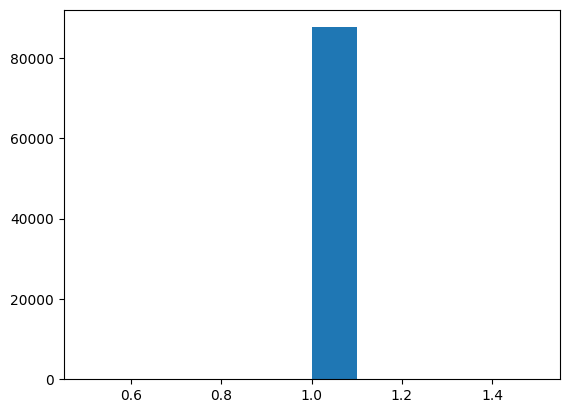

In [134]:
plt.hist(answers_no)

{'whiskers': [<matplotlib.lines.Line2D at 0x263f203ad10>,
 'caps': [<matplotlib.lines.Line2D at 0x263f2028150>,
 'boxes': [<matplotlib.lines.Line2D at 0x263f2076050>],
 'medians': [<matplotlib.lines.Line2D at 0x263f2029190>],
 'fliers': [<matplotlib.lines.Line2D at 0x263f2029910>],
 'means': []}

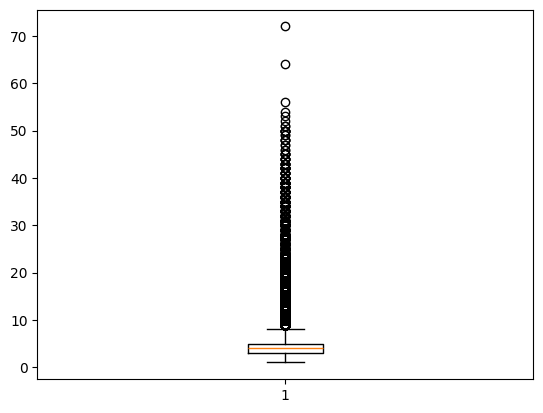

In [135]:
plt.boxplot(tokens_no)

In [136]:
empty_answers

425

In [137]:
partial_incorrect_indices = np.where(np.array(percentage_correct) < 1.0)
len(partial_incorrect_indices[0])

(array([   49,   116,   412,   457,   605,   628,   633,   991,  1077,
         1521,  1527,  1532,  1590,  1595,  1600,  1630,  1842,  1909,
         1914,  2116,  2123,  2243,  2478,  2491,  2499,  2501,  2608,
         2645,  2715,  3019,  3078,  3241,  3355,  3472,  3490,  4010,
         4051,  4168,  4182,  4227,  4657,  5121,  5314,  5919,  5924,
         5946,  5949,  5990,  5992,  6015,  6190,  6314,  6316,  6526,
         6608,  6735,  6769,  6985,  7146,  7149,  7151,  7486,  7528,
         7529,  7622,  7625,  7626,  7676,  7678,  7962,  8189,  8555,
         8638,  8735,  8816,  8835,  9030,  9213,  9235,  9250,  9745,
         9762, 10058, 10227, 11458, 11777, 11780, 11797, 11801, 11802,
        12027, 12189, 12370, 12765, 12874, 12888, 12966, 13060, 13197,
        13232, 13489, 13491, 13545, 13551, 13552, 13576, 13601, 13614,
        13787, 13791, 13799, 13863, 14079, 14377, 14448, 14473, 14516,
        14589, 14645, 14844, 14868, 14917, 15179, 15246, 15865, 16124,
      

{'whiskers': [<matplotlib.lines.Line2D at 0x263f1fc8110>,
 'caps': [<matplotlib.lines.Line2D at 0x263f1fc98d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x263f1fdb7d0>],
 'medians': [<matplotlib.lines.Line2D at 0x263f1fcae10>],
 'fliers': [<matplotlib.lines.Line2D at 0x263f1fcb890>],
 'means': []}

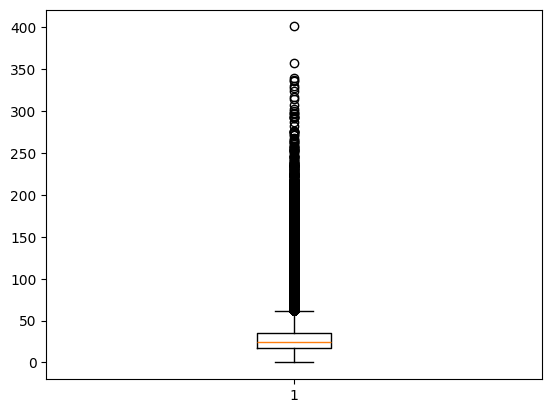

In [139]:
plt.boxplot(all_answers_lengths)

In [140]:
max(all_answers_lengths)

401